In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

In [60]:
from nltk.tokenize import word_tokenize
import gensim
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Input,Concatenate, Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [61]:
from tensorflow.keras import backend

In [62]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")

In [63]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


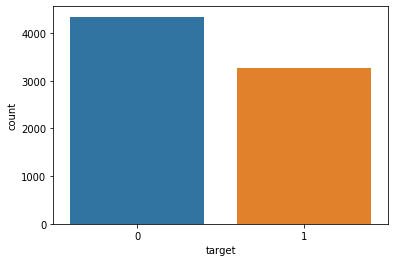

In [64]:
# Ratio of target
sns.countplot(train["target"])

In [65]:
train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [66]:
#Missing value count
round((train.isnull().sum()/len(train))*100,2)

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

In [67]:
#Unique Keywords and Locations in training
len(train['keyword'].unique())

222

In [68]:
#Unique Keywords and Locations in test
len(test['keyword'].unique())

222

In [69]:
set(test['keyword']) == set(train['keyword'])

True

In [70]:
#Look at the data
train[13:20]

,id,keyword,location,text,target
13,19,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,1
14,20,NaN,NaN,Damage to school bus on 80 in multi car crash ...,1
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0


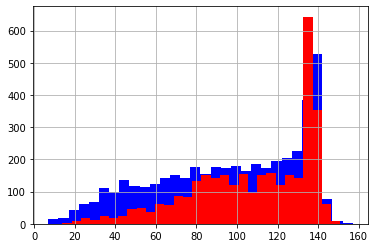

In [71]:
#Tweet Analysis by length of sentence
#fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
train[train['target']==0]['text'].str.len().hist(color="blue",bins=30)
train[train['target']==1]['text'].str.len().hist(color="red",bins=30)


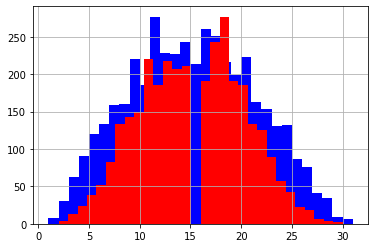

In [72]:
#Tweet Analysis by length of words
train[train['target']==0]['text'].str.split().map(lambda x: len(x)).hist(color="blue",bins=30)
train[train['target']==1]['text'].str.split().map(lambda x: len(x)).hist(color="red",bins=30)


In [73]:
#Distribution of Keywards in disaster vs non disaster tweets
print ("Number of unique keywords in training are: ",len(train['keyword'].unique()))


Number of unique keywords in training are:  222


In [74]:
train['target_mean']=train.groupby('keyword')['target'].transform('mean')

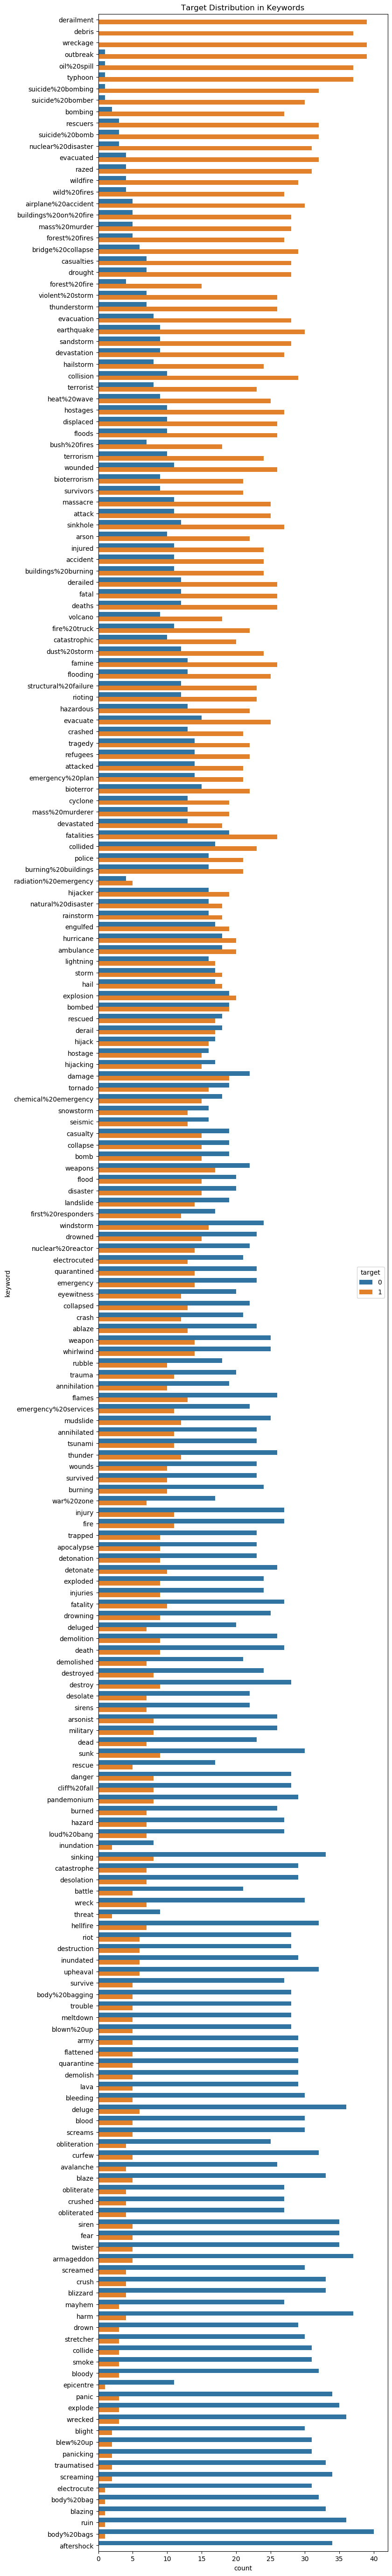

In [75]:
fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(y=train.sort_values(by='target_mean',ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean',ascending=False)['target'],data=train)
plt.title('Target Distribution in Keywords')
plt.show()

In [76]:
train.drop(columns=['target_mean'], inplace=True)

In [77]:
train['char_count']=train['text'].apply(lambda x: len(str(x)))
test['char_count']=test['text'].apply(lambda x: len(str(x)))

In [78]:
train['word_count']=train['text'].apply(lambda x: len(str(x).split()))
test['word_count']=test['text'].apply(lambda x: len(str(x).split()))

In [79]:
stpwrds=set(stopwords.words('english'))
train['stpwrd_count']=train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stpwrds]))
test['stpwrd_count']=test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stpwrds]))

In [80]:
#Usage of special characters in tweets
import string
puncs=string.punctuation
train['puncs_count']=train['text'].apply(lambda x: len([w for w in str(x) if w in puncs]))
test['puncs_count']=test['text'].apply(lambda x: len([w for w in str(x) if w in puncs]))

In [81]:
train['text'].apply(lambda x: len([w for w in str(x) if w in puncs]))

0        1
1        1
2        3
3        2
4        2
        ..
7608     5
7609     5
7610    11
7611     5
7612     7
Name: text, Length: 7613, dtype: int64

In [82]:
train['url_count']= train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count']= test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

In [83]:
train.head()

,id,keyword,location,text,target,char_count,word_count,stpwrd_count,puncs_count,url_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,6,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,11,3,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,2,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,7,2,0


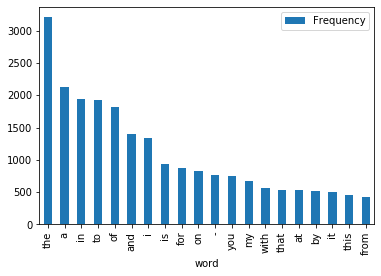

In [84]:
#Most common stopwords
from collections import Counter
#Counter(" ".join(train["text"]).split()).most_common(100)
temp=pd.Series(' '.join(train.text).lower().split()).value_counts()[:20]
temp.to_frame().reset_index().rename(columns= {'index': 'word',0:'Frequency'}).plot.bar(x='word',y='Frequency')

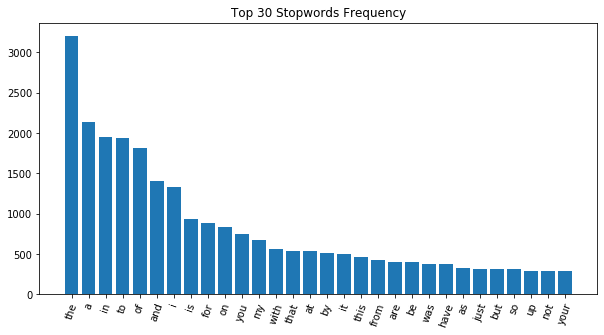

In [85]:
stpwrds=set(stopwords.words('english'))
temp=(' '.join(train.text).lower().split())
temp=[w for w in temp if w in stpwrds]
counts= dict(Counter(temp).most_common(30))
labels, values = zip(*counts.items())
# sort your values in descending order
indSort = np.argsort(values)[::-1]
# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))
fig = plt.figure(figsize=(10, 5))
plt.bar(indexes, values)
# add labels
plt.title('Top 30 Stopwords Frequency')
plt.xticks(indexes, labels,rotation=70)
plt.show()

In [86]:
#Cleaning of text 
train['text_punct_removed']=train['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
test['text_punct_removed']=test['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [87]:
import re
def url_remover(text):
    urlformat = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(urlformat,r'',text)
url_remover("New competition launched :https://www.kaggle.com/c/nlp-getting-started")

'New competition launched :'

In [88]:
#Find duplciate tweets with different target mapping 
duplicate_vals=train.groupby('text_punct_removed').nunique().sort_values(by='target',ascending=False)
duplicate_vals= duplicate_vals[duplicate_vals['target'] >1]['target']
duplicate_vals=duplicate_vals.index.tolist()

In [89]:
#Add a column wih val =1 for removing those entries from training giving conflciting versions
train['to_be_removed']= train['text_punct_removed'].apply(lambda x: 1 if x in duplicate_vals else 0)
train.groupby('text_punct_removed').nunique().sort_values(by='to_be_removed',ascending=False)
#Drop these rows
train = train[train.to_be_removed != 1]

In [90]:
train.drop(labels='to_be_removed',inplace=True,axis=1)

In [91]:

train.head()

,id,keyword,location,text,target,char_count,word_count,stpwrd_count,puncs_count,url_count,text_punct_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,6,1,0,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,0,1,0,Forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,11,3,0,All residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,1,2,0,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,7,2,0,Just got sent this photo from Ruby Alaska as s...


In [92]:
df=pd.concat([train,test])

In [93]:
df['text'] = df['text'].apply(lambda x: url_remover(x))

In [94]:
df['text_punct_removed']=df['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [95]:
df['text_punct_removed']=df['text_punct_removed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stpwrds)]))

In [96]:
#Using Glove Embeddings

embeddings_dict = {}
with open('../glove.6B.100d.txt', 'r',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
f.close()

In [97]:
#Convert words into integers
#With the Tokenizer from Keras, we convert the tweets into sequences of integers. 
#We limit the number of words to the NB_WORDS most frequent words.
tk = Tokenizer()
tk.fit_on_texts(df['text_punct_removed'])

In [98]:
#print(tk.word_counts)
#print(tk.document_count)
#print(tk.word_index)
#print(tk.word_docs)

In [99]:
X_df_seq = tk.texts_to_sequences(df['text_punct_removed'])
X_df_seq_trunc = pad_sequences(X_df_seq, maxlen=50,padding='post',truncating='post')

In [100]:
word_index=tk.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22778


In [101]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))
for word,i in tqdm(word_index.items()):
    #if i > num_words:
        #continue
    emb_vec= embeddings_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 22778/22778 [00:00<00:00, 250311.41it/s]


In [102]:
trainingdata=X_df_seq_trunc[:train.shape[0]]
testdata=X_df_seq_trunc[train.shape[0]:]

In [103]:
temp_train=train.copy()
temp_train.columns
temp_train=temp_train[['char_count','word_count','stpwrd_count', 'puncs_count', 'url_count']]
temp_train.shape

(7549, 5)

In [104]:
temp_test=df[train.shape[0]:]
print(temp_test.columns)
temp_test=temp_test[['char_count','word_count','stpwrd_count', 'puncs_count', 'url_count']]
print(temp_test.shape)
temp_test=temp_test.to_numpy()

Index(['id', 'keyword', 'location', 'text', 'target', 'char_count',
       'word_count', 'stpwrd_count', 'puncs_count', 'url_count',
       'text_punct_removed'],
      dtype='object')
(3263, 5)


In [105]:
#To get indices of test train split
indices = np.arange(trainingdata.shape[0])

In [106]:
X_train,X_test,y_train,y_test,idx1, idx2=train_test_split(trainingdata,train['target'].values,indices,test_size=0.15)

In [107]:
X_train_temp=temp_train.iloc[idx1,:]
X_train_temp=X_train_temp.to_numpy()
X_test_temp=temp_train.iloc[idx2,:]
X_test_temp=X_test_temp.to_numpy()

In [108]:
X_train,X_test,y_train,y_test=train_test_split(trainingdata,train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6416, 50)
Shape of Validation  (1133, 50)


In [53]:
model=Sequential()
embedding= Embedding(num_words,100,embeddings_initializer =Constant(embedding_matrix),input_length=50,trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.1))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])


In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2277900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,296,013
Trainable params: 18,113
Non-trainable params: 2,277,900
_________________________________________________________________


In [58]:
history=model.fit(X_train,y_train,batch_size=16,epochs=1,validation_data=(X_test,y_test),verbose=2)


Train on 6416 samples, validate on 1133 samples
6416/6416 - 10s - loss: 0.5433 - accuracy: 0.7575 - val_loss: 0.5012 - val_accuracy: 0.7793


In [177]:
sample_sub=pd.read_csv('sample_submission.csv')

In [ ]:
y_pre=model.predict(testdata)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

In [213]:
sequence_input = Input(shape=(50,), dtype='int32')
embedded_sequences = Embedding(num_words,100,embeddings_initializer =Constant(embedding_matrix),input_length=50,trainable=False)(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

preds = Dense(1, activation='sigmoid')(x)
optimzer=Adam(learning_rate=1e-4)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=optimzer,
              metrics=['accuracy'])


#model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])
# happy learning!
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 50, 100)           2934900   
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 46, 128)           64128     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0   

In [299]:
#model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=128)
#history=model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),verbose=2)

In [113]:
main_input = Input(shape=(50,), dtype='float32', name='main_input')
x= Embedding(num_words,100,embeddings_initializer =Constant(embedding_matrix),input_length=50,trainable=False)(main_input)
x =SpatialDropout1D(0.2)(x)
lstm_out = LSTM(64, dropout=0.2, recurrent_dropout=0.1)(x)
auxiliary_input = Input(shape=(5,), name='aux_input',dtype='float32')
x = Concatenate(axis=1)([lstm_out, auxiliary_input])
x = Dense(64, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
main_output  = Dense(1, activation='sigmoid',name= 'main_output')(x)
optimzer=Adam(learning_rate=1e-4)
model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [117]:
history=model.fit([X_train, X_train_temp], y_train, epochs=20, batch_size=32, validation_data=([X_test,X_test_temp],y_test))
#history=model.fit(X_train,y_train,batch_size=16,epochs=20,validation_data=(X_test,y_test),verbose=2)

Train on 6416 samples, validate on 1133 samples
Epoch 1/20
6416/6416 [==============================] - 6s 878us/sample - loss: 0.4476 - accuracy: 0.8036 - val_loss: 0.4991 - val_accuracy: 0.7873
Epoch 2/20
6416/6416 [==============================] - 6s 970us/sample - loss: 0.4450 - accuracy: 0.8056 - val_loss: 0.4926 - val_accuracy: 0.7846
Epoch 3/20
6416/6416 [==============================] - 8s 1ms/sample - loss: 0.4478 - accuracy: 0.8064 - val_loss: 0.4987 - val_accuracy: 0.7838
Epoch 4/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4448 - accuracy: 0.8086 - val_loss: 0.4897 - val_accuracy: 0.7820
Epoch 5/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4454 - accuracy: 0.8042 - val_loss: 0.4829 - val_accuracy: 0.7785
Epoch 6/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4456 - accuracy: 0.8055 - val_loss: 0.4785 - val_accuracy: 0.7811
Epoch 7/20
6416/6416 [==============================] - 7s 1ms/sample - 

In [121]:
history=model.fit([X_train, X_train_temp], y_train, epochs=20, batch_size=32, validation_data=([X_test,X_test_temp],y_test))

Train on 6416 samples, validate on 1133 samples
Epoch 1/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4266 - accuracy: 0.8155 - val_loss: 0.4813 - val_accuracy: 0.7935
Epoch 2/20
6416/6416 [==============================] - 6s 948us/sample - loss: 0.4299 - accuracy: 0.8105 - val_loss: 0.4784 - val_accuracy: 0.7961
Epoch 3/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4313 - accuracy: 0.8123 - val_loss: 0.4899 - val_accuracy: 0.7944
Epoch 4/20
6416/6416 [==============================] - 7s 1ms/sample - loss: 0.4301 - accuracy: 0.8197 - val_loss: 0.4817 - val_accuracy: 0.7891
Epoch 5/20
6416/6416 [==============================] - 8s 1ms/sample - loss: 0.4250 - accuracy: 0.8159 - val_loss: 0.4821 - val_accuracy: 0.7873
Epoch 6/20
6416/6416 [==============================] - 9s 1ms/sample - loss: 0.4232 - accuracy: 0.8153 - val_loss: 0.4797 - val_accuracy: 0.7944
Epoch 7/20
6416/6416 [==============================] - 9s 1ms/sample - lo

In [67]:
X_train_temp=backend.cast(X_train_temp,'float32')
X_train= backend.cast(X_train,'float32')

In [118]:
testdata=backend.cast(testdata,'float32')
temp_test= backend.cast(temp_test,'float32')

In [119]:
sample_sub=pd.read_csv('sample_submission.csv')
y_pre=model.predict([testdata,temp_test])
print(y_pre)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)
y_pre

[[0.7925914 ]
 [0.6449011 ]
 [0.9276518 ]
 ...
 [0.7415862 ]
 [0.66237444]
 [0.44658995]]


array([1, 1, 1, ..., 1, 1, 0])

In [120]:
y_pre

array([1, 1, 1, ..., 1, 1, 0])